# Large Turbine Wind Speed and Power Predictions
**Author:** Ian Eykamp, **Date:** July 27, 2023

## Purpose
To give an estimate of the voltage and power that will be generated by the large wind turbine during operation on Olin's campus. This will be useful for speccing a dump load resistor, which is done at the end of this document.

## Assumptions
In this exploration, I used several secondary sources that all refer (I think) to the specific model of turbine and generator that we have at Olin. [One](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E1%20Final%20Design%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources) is a write-up of a similar installation by Eastern Wind Power on top of a building, along with modeled vs. measured power outputs. It is an assumption that those measurements will be valid at Olin at the same wind speed levels. The average wind speed at Olin is much lower, which might mean the bulk of the data gathered at that site is not relevant.

Another secondary source is the PLECS model for the "1FW3208-1EE" generator supplied with a constant speed of rotation (in rpm). This model was provided by Supa as part of several other PLECS models attemting to answer a similar question. I have no way to confirm the accuracy of that model.

Despite these caveats, a sign that I am in the right ballpark is that the results from all of the data I chose to analyze do approximately line up. Moreover, my final recommendation of a 12m/s cut-out wind speed is both in the ballpark of other recommendations and is a more conservative number than all other estimates. In this case, it does not hurt to be conservative, because even at 12m/s, it is very rare that we will ever reach the cut-out wind speed on Olin's campus since our wind speeds are very low on average.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: <object object at 0x000002A0B74EB4E0>



## Secondary Sources For Power vs. Wind Speed
### Dylan and Anna's OneDrive
Dylan Merzenich and Anna Letcher Hartman worked on the mechanical side of the turbine, designing a 6-foot tower for the turbine to sit on. Their work is consolidated [here](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx) (you will need OneDrive permission).

On page 3 of this [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E2%20Aerodynamic%20load%20analysis%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources), there is a table linking wind speed to generator revolutions per minute. This is tabulated using Pandas in the script below.

![Eastern Wind Power wind speed vs. generator revolutions per minute table](eastern_wind_power_wind_speed_rpm.png)

In [2]:
df_rotor_speed = pd.DataFrame(
    columns = ["Load Case #", "Wind Speed (m/s)", "Rotor Speed (rpm)", "Rotor Speed (rad/s)", "Tip Speed Ratio (TSR)"], 
    data = [
        [1,  2,  23,  2.4,  3.0],
        [2,  4,  46,  4.8,  3.0],
        [3,  6,  69,  7.2,  3.0],
        [4,  8,  92,  9.6,  3.0],
        [5,  10, 115, 12.0, 3.0],
        [6,  12, 138, 14.5, 3.0],
        [7,  14, 160, 16.8, 3.0],
        [8,  16, 183, 19.2, 3.0],
        [9,  18, 206, 21.6, 3.0],
        [10, 20, 229, 24.0, 3.0],
        [11, 22, 252, 26.4, 3.0],
    ]
).set_index("Load Case #")
print(df_rotor_speed)

             Wind Speed (m/s)  Rotor Speed (rpm)  Rotor Speed (rad/s)  \
Load Case #                                                             
1                           2                 23                  2.4   
2                           4                 46                  4.8   
3                           6                 69                  7.2   
4                           8                 92                  9.6   
5                          10                115                 12.0   
6                          12                138                 14.5   
7                          14                160                 16.8   
8                          16                183                 19.2   
9                          18                206                 21.6   
10                         20                229                 24.0   
11                         22                252                 26.4   

             Tip Speed Ratio (TSR)  
Load Case #  

Page 13 of ths [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E1%20Final%20Design%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources&ga=1) has a graph of theoretical power output vs. wind speed based on a model used by Eastern Wind Power. It shows much higher power generation than any other source, so it can probably be used as an upper bound. It shows a cut-in wind speed of 2m/s and a cut-out at 18m/s, after which the rotor is shut down. If you extrapolate past the cut-out point, you would reach around 55kW at 20m/s, or 25kW at 15m/s.

![Eastern Wind Power wind speed vs. generator power (theoretical)](eastern_wind_power_wind_speed_power_theoretical.png)

I tabulated the data for use in this script by reading off the graph.

In [3]:
df_EWP_modeled = pd.DataFrame(
    columns = ["Wind Speed (m/s)", "Power Output (kW)"], 
    data = [
        [1,  0.00],
        [2,  0.00],
        [3,  0.00],
        [4,  0.5],
        [5,  1.5],
        [6,  2.1],
        [7,  2.7],
        [8,  4],
        [9,  5.6],
        [10, 7.4],
        [11, 9.8],
        [12, 12.3],
        [13, 15.5],
        [14, 19],
        [15, 23.8],
        [16, 28.2],
        [17, 37.4],
        [18, 45.8],
        [19, 42],
        [20, 55],
    ]
)
print(df_EWP_modeled)

    Wind Speed (m/s)  Power Output (kW)
0                  1                0.0
1                  2                0.0
2                  3                0.0
3                  4                0.5
4                  5                1.5
5                  6                2.1
6                  7                2.7
7                  8                4.0
8                  9                5.6
9                 10                7.4
10                11                9.8
11                12               12.3
12                13               15.5
13                14               19.0
14                15               23.8
15                16               28.2
16                17               37.4
17                18               45.8
18                19               42.0
19                20               55.0


Page 15 of the same [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E1%20Final%20Design%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources&ga=1) has a graph of the power output vs. wind speed that they actually measured. They have a cut-in point at 4m/s. Notably, they have a cut-out point at around 13m/s, at which point the rotor is controlled so that it doesn't spin any faster. At around 20m/s wind speed, the rotor is shut down completely.

I had access to an extended version of the same document as a hard copy (accessed from the Eastern Wind Power binders in Chhavi's lab), and it contains tabulted data from the graph, which is reproduced below.

![Eastern Wind Power wind speed vs. generator power (measured)](eastern_wind_power_wind_speed_power_measured.png)

In [4]:
df_EWP_measured = pd.DataFrame(
    columns = ["Wind Speed (m/s)", "Power Output (kW)"], 
    data = [
        [0.5,  0.00],
        [1.0,  0.00],
        [1.5,  0.00],
        [2.0,  0.00],
        [2.5,  0.00],
        [3.0,  0.00],
        [3.5,  0.00],
        [4.0,  0.19],
        [4.5,  0.33],
        [5.0,  0.51],
        [5.5,  0.71],
        [6.0,  1.00],
        [6.5,  1.38],
        [7.0,  1.74],
        [7.5,  2.27],
        [8.0,  2.58],
        [8.5,  3.23],
        [9.0,  4.04],
        [9.5,  4.67],
        [10.0, 5.41],
        [10.5, 6.59],
        [11.0, 7.58],
        [11.5, 9.18],
        [12.0, 9.40],
        [12.5, 10.20],
        [13.0, 10.82],
        [13.5, 13.01],
        [14.0, 13.01],
        [14.5, 13.01],
        [15.0, 13.01],
    ]
)
print(df_EWP_measured)

    Wind Speed (m/s)  Power Output (kW)
0                0.5               0.00
1                1.0               0.00
2                1.5               0.00
3                2.0               0.00
4                2.5               0.00
5                3.0               0.00
6                3.5               0.00
7                4.0               0.19
8                4.5               0.33
9                5.0               0.51
10               5.5               0.71
11               6.0               1.00
12               6.5               1.38
13               7.0               1.74
14               7.5               2.27
15               8.0               2.58
16               8.5               3.23
17               9.0               4.04
18               9.5               4.67
19              10.0               5.41
20              10.5               6.59
21              11.0               7.58
22              11.5               9.18
23              12.0               9.40


### PLECS Model
I used the basic generator model connected to three resistors in a delta configuration as a dump load. The power dissipated by the dump load is dependent on the resistance and is maximized when the impedance of the load matches the internal impedance of the generator (refer to any textbook). The power dissipated is also obviously dependent on the rotor speed. I ran a basic 2-dimensional parameter sweep of the load resistance and rotor speed for $1\Omega \le R_{Load} \le 10\Omega$ and $50\text{rpm} \le \omega \le 300\text{rpm}$.

![Parameter Sweep PLECS Model](plecs/parameter_sweep_schematic.png)

The script can be accessed from `Simulation -> Simulation Scripts` or by pressing `Ctrl+Shift+T` and has contents

```
mdl = plecs('get', '', 'CurrentCircuit');
scopepath = [mdl '/Total Power Scope'];
displaypath = [mdl '/Total Power Display'];

loadStructure = struct('RL1', 4);
loadStructure = struct('RL2', 4);
loadStructure = struct('RL3', 4);
loadStructure = struct('wr', 100);
varStructure = struct('ModelVars', loadStructure);

plecs('scope', scopepath, 'ClearTraces');

RVals = [1:10:200];
wVals = [210:50:300];

for ix = 1:length(RVals)
  varStructure.ModelVars.RL1 = RVals(ix);
  varStructure.ModelVars.RL2 = RVals(ix);
  varStructure.ModelVars.RL3 = RVals(ix);
  for jx = 1:length(wVals)
    varStructure.ModelVars.wr = wVals(jx);
    
    printf('\n');
    output = plecs('simulate', varStructure);
    printf('\n');

    [nrows, ncols] = size(output.Values(1,:));   % determine number of row and column in structure
    [finalValue] = output.Values(1, ncols); % % determine last value of inductor current in this run
    % Output the last value of Inductor Current in current run  
    printf('RL = %dohms, wr = %drpm, power = %dW', RVals(ix), wVals(jx), finalValue);
    plecs('scope', scopepath, 'HoldTrace', ['R = ' mat2str(RVals(ix)) ' ohms']);
  end
end
```

The script prints the results of the parameter sweep into the PLECS simulation console, which can be viewed from `Window -> Show Console`. From there, I copied all the text and pasted it into a file named `plecs_parameter_sweep_3.txt`. There are random printouts between each line that I don't know how to get rid of. Instead, I filter out those lines when I read the file into python.

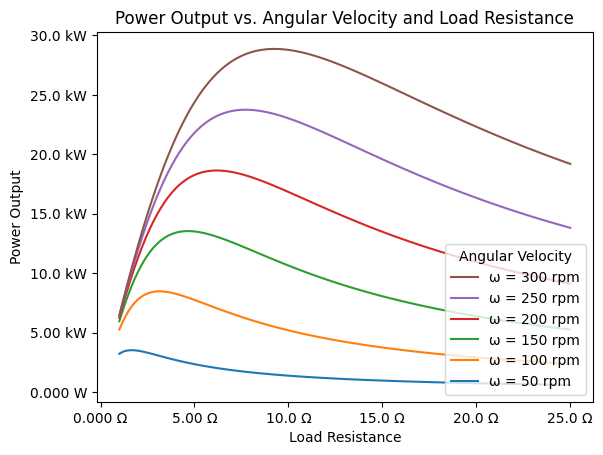

In [5]:
def get_params(param_str):
    resistance = float(param_str.partition("RL = ")[2].partition("ohms")[0])
    angular_velocity = float(param_str.partition("wr = ")[2].partition("rpm")[0])
    power = float(param_str.partition("power = ")[2].partition("W")[0])
    return resistance, angular_velocity, power

df_plecs = pd.DataFrame(columns = ["Resistance (ohms)", "Angular Velocity (rpm)", "Power (W)"])
with open("plecs/plecs_parameter_sweep_3.txt") as file:
    for line in file:
        if line.startswith("Kt") or line.startswith("Imax") or line.strip() == "":
            continue
        resistance, angular_velocity, power = get_params(line)
        df_plecs.loc[len(df_plecs)] = ([resistance, angular_velocity, power])

# print(df_plecs)

grouped_by_angular_velocity = df_plecs.groupby("Angular Velocity (rpm)")

fig, ax1 = plt.subplots()
helper.axes_labels("Load Resistance", "Ω", "Power Output", "W", title = "Power Output vs. Angular Velocity and Load Resistance")
for angular_velocity, group in grouped_by_angular_velocity:
    plt.plot(group["Resistance (ohms)"], group["Power (W)"], label = f"ω = {angular_velocity:.0f} rpm")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(reversed(handles), reversed(labels), title = "Angular Velocity", loc='lower right')

Lastly, I find the peak power output as well as the ideal resistance to produce it for each rotor speed (angular velocity).

In [6]:
df_plecs_peak = pd.DataFrame(columns = ["Peak Resistance (ohms)", "Angular Velocity (rpm)", "Peak Power (W)"])

grouped_by_angular_velocity = df_plecs.groupby("Angular Velocity (rpm)")

for angular_velocity, group in grouped_by_angular_velocity:
    peak_idx = group["Power (W)"].argmax()
    peak_resistance = group["Resistance (ohms)"].iloc[peak_idx]
    peak_power = group["Power (W)"].iloc[peak_idx]
    df_plecs_peak.loc[len(df_plecs_peak)] = ([peak_resistance, angular_velocity, peak_power])

print(df_plecs_peak[["Angular Velocity (rpm)", "Peak Resistance (ohms)", "Peak Power (W)"]])


   Angular Velocity (rpm)  Peak Resistance (ohms)  Peak Power (W)
0                    50.0                     1.6         3523.79
1                   100.0                     3.2         8474.87
2                   150.0                     4.6        13542.80
3                   200.0                     6.2        18641.60
4                   250.0                     7.8        23750.70
5                   300.0                     9.2        28868.00


### Generate Tables
Now it's time to put all the data from these different sources together. I compare all the above datasets at several particularly relevant wind velocities. This involves linear interpolation when the exact values are not available.

In [7]:
wind_speeds_to_tabulate = [20, 15, 12, 9, 6, 4, 2]

# this function courtesy of https://stackoverflow.com/a/51535881
def reindex_and_interpolate(df, new_index):
    return df.reindex(df.index | new_index).interpolate(method='index', limit_direction='both').loc[new_index]

df_final_rotor_speeds = reindex_and_interpolate(df_rotor_speed.set_index("Wind Speed (m/s)"), wind_speeds_to_tabulate)
# print(df_final_rotor_speeds)
df_final_plecs = reindex_and_interpolate(df_plecs_peak.set_index("Angular Velocity (rpm)"), df_final_rotor_speeds["Rotor Speed (rpm)"])
df_final_plecs["Peak Power (kW)"] = df_final_plecs["Peak Power (W)"] / 1000
# print(df_final_plecs)
df_final_EWP_measured = reindex_and_interpolate(df_EWP_measured.set_index("Wind Speed (m/s)"), wind_speeds_to_tabulate)
# print(df_final_EWP_measured)
df_final_EWP_modeled = reindex_and_interpolate(df_EWP_modeled.set_index("Wind Speed (m/s)"), wind_speeds_to_tabulate)
# print(df_final_EWP_modeled)

df_joined = df_final_rotor_speeds
df_joined = df_joined.join(
    df_final_EWP_modeled.rename({
        "Power Output (kW)": "Power Output [EWP Modeled] (kW)"
    }, axis = "columns")
)
df_joined = df_joined.join(
    df_final_EWP_measured.rename({
        "Power Output (kW)": "Power Output [EWP Measured] (kW)"
    }, axis = "columns")
)
df_joined = df_joined.join(
    df_final_plecs.rename({
        "Angular Velocity (rpm)": "Rotor Speed (rpm)", 
        "Peak Resistance (ohms)": "Ideal Load Resistance [PLECS] (ohms)", 
        "Peak Power (kW)": "Dump Load Max. Power Output [PLECS] (kW)"
    }, axis = "columns"), 
    on = "Rotor Speed (rpm)"
)
df_final = df_joined.reset_index()[[
    "Wind Speed (m/s)", 
    "Rotor Speed (rpm)", 
    "Power Output [EWP Modeled] (kW)", 
    "Power Output [EWP Measured] (kW)", 
    "Dump Load Max. Power Output [PLECS] (kW)", 
    "Ideal Load Resistance [PLECS] (ohms)", 
    ]]

# print(df_final.to_markdown())
df_final.round(decimals = 1)

C:\Users\ieykamp\AppData\Local\Temp\ipykernel_23592\172120132.py:5: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  return df.reindex(df.index | new_index).interpolate(method='index', limit_direction='both').loc[new_index]


,Wind Speed (m/s),Rotor Speed (rpm),Power Output [EWP Modeled] (kW),Power Output [EWP Measured] (kW),Dump Load Max. Power Output [PLECS] (kW),Ideal Load Resistance [PLECS] (ohms)
0,20,229.0,55.0,13.0,21.6,7.1
1,15,171.5,23.8,13.0,15.7,5.3
2,12,138.0,12.3,9.4,12.3,4.3
3,9,103.5,5.6,4.0,8.8,3.3
4,6,69.0,2.1,1.0,5.4,2.2
5,4,46.0,0.5,0.2,3.5,1.6
6,2,23.0,0.0,0.0,3.5,1.6


### Conclusions From The Above Data
There is considerable variation between the sources, but they all agree that around 20m/s wind speed, the rotor speed is at or below 250rpm, probably closer to 225rpm. At 20m/s, the Eastern Wind Power model predicts close to 50kW, whereas the PLECS model predicts 25kW at the optimal load resistance. The Eastern Wind Power measured data does not go up to 20m/s; instead, it controls the rotor speed to never exceed the power produced at 13m/s, which is about 13kW.

At around 15m/s wind speed, rotor speed should be under 180rpm; the EWP model predicts 25kW, which is significantly more than the measured EWP data (<15kW). The PLECS model is closer to the measured data, slightly above 15kW.

At around 12m/s wind speed, the rotor speed should be under 150rpm; the EWP model predicts 12kW; EWP data suggests 10kW; and the PLECS model at 150rpm yields about 14kW. In all cases, this is less than the 15kW dump load capacity we can get most cheaply from configuring three 5kW resistors in a delta formation. According to the PLECS model, they will be able to dissipate the most power when each of the load resistors is 5 ohms.

I would advocate for using 12m/s as our cut-out wind speed above which we will activate the brakes, because then we can use the cheapest 15kW dump load capacity. By cheapest, I mean $450 instead of $900 if we need six resistors instead of three.

### Comparison with other recommendations

On page 31 of this [document](https://olincollege-my.sharepoint.com/personal/dmerzenich_olin_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources%2F3%2E1%2E1%20Final%20Design%2Epdf&parent=%2Fpersonal%2Fdmerzenich%5Folin%5Fedu%2FDocuments%2FJust%20Energy%20Capstone%2F3%20Resources%2F3%2E1%20Eastern%20Wind%20Power%20Resources&ga=1), the design parameters are listed. This suggests that at 20m/s wind speed, the generator will be rotating at 215rpm, at which point the pneumatic brakes will be applied. This is the value that Supa referenced to me via email.

However, according to the earlier figure in the same document, the rotor speed is limited starting at around 13m/s, and it is not allowed to produce more than 13kW of power even at higher wind speeds. For us, this speed-limiting control is not possible, so we would have to shut down the whole rotor rather than allowing it to keep spinning above 13m/s.

![Eastern Wind Power design parameters table](eastern_wind_power_parameters_table.png)

Finally, Slide 10 of Dylan and Anna's [presentation](https://olincollege-my.sharepoint.com/:p:/r/personal/dmerzenich_olin_edu/_layouts/15/Doc.aspx?sourcedoc=%7B0CB9372D-7ADA-405B-8642-884E389CB85F%7D&file=Final%20Presentation.pptx&action=edit&mobileredirect=true) suggests having a cut-out wind speed of 15m/s. This is in the same ballpark range, but according to the PLECS model, it might produce more than 15kW of power, thus overloading the dump load resistors or requiring us to oversize them. I think a more conservative cut-out wind speed of 12m/s is preferable.

## Primary Source: Anemometer Data
I have data from an anemometer (wind speed measuring device) that has been active around campus for about a year (since sometime in the Fall 2022 semester when JEH ran as a class). The anemometer was moved several times, but the wind speed data was not significantly different.

To view and download the anemometer data, go to this [link](https://zentracloud.com/accounts/login/?next=/), and login with the following information.

![Zentra anemometer login information. Username: lvanasupa@olin.edu, Password: JustEnergyHub1](zentra_login.png)

The website shows the wind speed averaged to every few hours, as well as "gust speed," which I think means the maximum wind speed during each averaging time block. You can also download the minutely data and do the averaging yourself, as I have done below.

### Load data

In [8]:
data_file_path = "z6-20340(z6-20340)-Configuration 1-1689879751.4027638.csv"
cols_on_which_to_parse_dates = ['Timestamps']
df = pd.read_csv(data_file_path, skiprows = 2, parse_dates = cols_on_which_to_parse_dates)
# print(df.columns)

df_downsampled_unagreggated = df.set_index("Timestamps")[" m/s Wind Speed"].resample("D")

### Resample data
By resampling the data myself, I can perform multiple aggregation methods, such as finding the max, min, various percentiles, and mean for each averaged bin of data. Here, I am averaging the data daily. To change to hourly, for example, change the `resample("D")` line in the above code chunk to `resample("H")`.

In [9]:
df_downsampled = pd.DataFrame()
df_downsampled["max"] = df_downsampled_unagreggated.max()
df_downsampled["min"] = df_downsampled_unagreggated.min()
df_downsampled["90_percentile"] = df_downsampled_unagreggated.quantile(0.9)
df_downsampled["10_percentile"] = df_downsampled_unagreggated.quantile(0.1)
df_downsampled["median"] = df_downsampled_unagreggated.quantile(0.5)
df_downsampled["sd"] = df_downsampled_unagreggated.std()
df_downsampled["mean"] = df_downsampled_unagreggated.mean()
# print(df_downsampled.head(3))

### Plot data

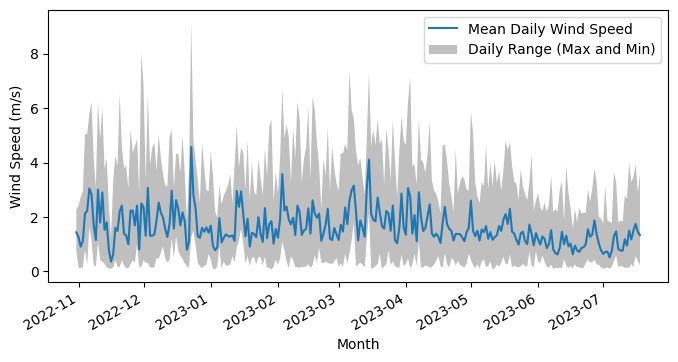

In [10]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, sharey = False, figsize = (8, 4))
ax1.plot(df_downsampled.index, df_downsampled["mean"], linestyle = "solid", label = "Mean Daily Wind Speed")
ax1.fill_between(df_downsampled.index, df_downsampled["max"], df_downsampled["min"], facecolor='gray', alpha=0.5, label = "Daily Range (Max and Min)")
fig.autofmt_xdate()
ax1.set_xlabel("Month")
ax1.set_ylabel("Wind Speed (m/s)")
ax1.legend()

According to the anemometer data, the average wind speed on Olin's campus is around 2m/s, which is below the realistic cut-in wind speed for the rotor to even spin. But consider that each data point in the above graph represents an entire day---any time the blue line peaks above 3m/s or 4m/s, that means the wind was blowing that strongly consistently for the entire day. More realistically, the wind will blow somewhere in the gray region for an hour or two out of the day---enough to get the turbine up to speed and keep it there for enough time to generate real power. Even still, most of the time the maximum wind speed is below 6m/s, and only once in the last year did it get to 9m/s.

In reality, nearly every day, the rotor will stay below 100rpm, maybe reaching 70rpm for an hour every couple days. In terms of power, this is no more than 4-6kW even on the windiest days.

Consider if we had set our cut-out wind speed to be 12m/s. In a whole year of wind speed data, we never would have had to shut down, even at this threshold. And if we know the brakes will come on above this wind speed, we can save a lot of money on making our dump load less beefy.

## Dump Load Resistors
We can configure three beefy resistors in a delta configuration to act as a three-phase dump load. The power rating of the dump load will be the sum of the power ratings of the three resistors. The highest power dissipating resistor available on the market is 5kW and comes from Digikey for $400, Amazon for $150, or various resellers on Ebay for around $100 apiece. Three 5kW resistors would give us 15kW of dump load power capacity. Increasing our cut-out speed to 20m/s would increase this to 30kW, meaning we would have to buy six resistors, and it would double the price.